In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysam

# HET SNVs distribution

In [2]:
def load_het_snps(path):
    snvs = defaultdict(list)
    with pysam.VariantFile(path) as f:
        sample = list(f.header.samples)[0]
        for record in f:
            gt = record.samples[sample]["GT"]
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]
            if len(a1) > 1 or len(a2) > 1 or a1 == a2:
                continue
            snvs[record.chrom].append(record.start)
    return snvs
snvs1 = load_het_snps("../../public/GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.vcf.gz")
snvs2 = load_het_snps("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round1/snvs.vcf.gz")

In [3]:
chroms = ["chr%d" % c for c in range(1, 23)] + ["chrX", "chrY"]
chrom_lengths = dict()
with open("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes") as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        chrom_lengths[chrom] = int(length)

In [4]:
def get_het_snv_density(snps, chrom_lengths, width=1000000):
    chrom_counts = dict()
    for chrom in chrom_lengths:
        length = chrom_lengths[chrom]
        nbin = int(length / width)
        if length % width > 0:
            nbin += 1
        counts = np.zeros(nbin, dtype=np.int)
        for p in snps[chrom]:
            counts[int(p / width)] += 1
        chrom_counts[chrom] = counts
    return chrom_counts

chrom_counts1 = get_het_snv_density(snvs1, chrom_lengths)
chrom_counts2 = get_het_snv_density(snvs2, chrom_lengths)

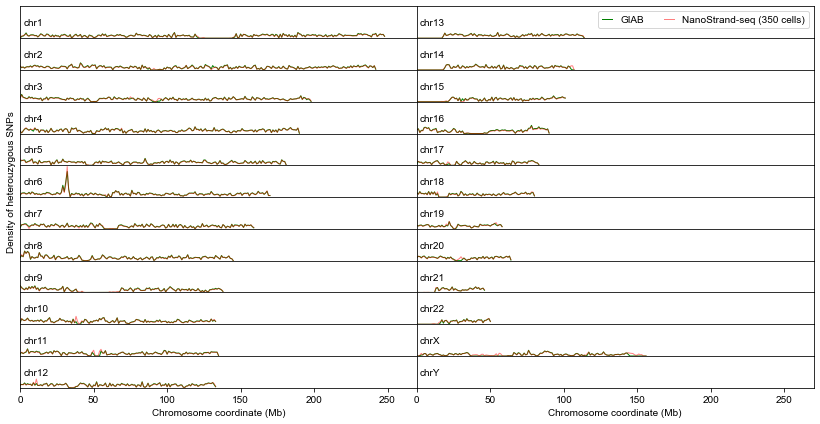

In [7]:
xlim = max([len(counts) for counts in chrom_counts1.values()])
ylim1 = max([max(counts) for counts in chrom_counts1.values()])
ylim2 = max([max(counts) for counts in chrom_counts2.values()])
ylim = max(ylim1, ylim2)
xlim = 270
ylim = 8000

fig, axs = plt.subplots(12, 2, figsize=(11.5, 6), sharex=True, sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})

for i, chrom in enumerate(chroms):
    nrow = i % 12
    ncol = int(i / 12)
    ax = axs[nrow][ncol]
    plt.sca(ax)
    
    ys1 = chrom_counts1[chrom]
    ys2 = chrom_counts2[chrom]
    xs = np.arange(len(ys1))

    plt.plot(xs, ys1, lw=1, color="green", alpha=1, label="GIAB")
    plt.plot(xs, ys2, lw=1, color="red", alpha=0.5, label="NanoStrand-seq (350 cells)")
    plt.text(2, ylim * 0.4, chrom)
    plt.yticks([])
    if nrow == 11:
        plt.xlabel("Chromosome coordinate (Mb)")

ax = axs[0][1]
ax.legend(ncol=2, frameon=True, bbox_to_anchor=(1, 1), loc="upper right", handlelength=1)

# ax = axs[11][1]
# ax.set_visible(False)

ax = axs[5][0]
ax.set_ylabel("Density of heterouzygous SNPs")

plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.tight_layout()
plt.savefig("figures/het_snp_distribution.pdf", dpi=300)

# Haplotype-resolved SNV distribution

deprecated

In [4]:
chroms = ["chr%d" % c for c in range(1, 23)] + ["chrX"]
chrom_lengths = dict()
with open("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes") as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        chrom_lengths[chrom] = int(length)

path = "../../A1_NanoStrandseqAssembly/results/HG001_Cell_350/round2/snvs.vcf.gz"
width = 1000000
snvs = dict()
with pysam.VariantFile(path) as f:
    sample = list(f.header.samples)[0]
    for chrom in chroms:
        length = chrom_lengths[chrom]
        nbin = int(length / width)
        if length % width > 0:
            nbin += 1
        hp1 = np.zeros(nbin)
        hp2 = np.zeros(nbin)
        for record in f.fetch(chrom):
            idx = int(record.start / width)
            gt = record.samples[sample]["GT"]
            if gt[0] != 0:
                hp1[idx] += 1
            if gt[1] != 0:
                hp2[idx] += 1
        snvs[chrom] = [hp1, hp2]

In [5]:
vs = []
for chrom in chroms:
    vs.extend(snvs[chrom][0])
    vs.extend(snvs[chrom][1])
np.mean(vs), np.std(vs), np.median(vs)

(765.6737844940867, 373.3334791906913, 774.0)

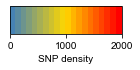

In [15]:
fig, ax = plt.subplots(figsize=(2, 1))
fig.subplots_adjust(bottom=0.5)
clist = ["steelblue", "gold", "red"]
vmax = 2000
def get_color(count):
    return cmap(min(0.99, count / vmax))
cmap = mpl.colors.LinearSegmentedColormap.from_list('chaos', clist, 20)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='SNP density')
fig.savefig("figures/haplotyped_snv_distribution.cbar.pdf", dpi=300)

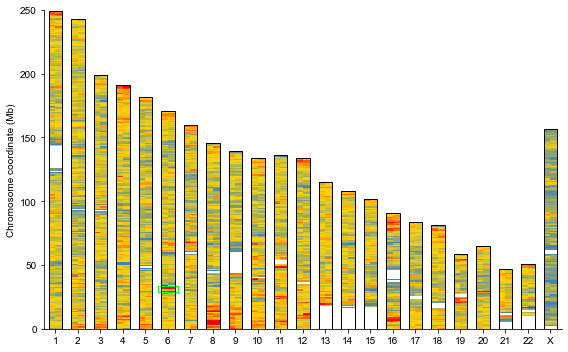

In [13]:
w = 0.3

plt.figure(figsize=(8, 5))

#
xs = []
ys = []
for i, chrom in enumerate(chroms):
    h = len(snvs[chrom][0]) * width
    xs.append(i)
    ys.append(h)
plt.bar(xs, ys, width=w * 2, edgecolor="black", color="none", lw=1, zorder=10)

#
xs = []
ys = []
bottoms = []
colors = []
for i, chrom in enumerate(chroms):
    #if chrom != "chr6":
    #    continue
    hp1, hp2 = snvs[chrom]
    for j, hp in enumerate([hp1, hp2]):
        if j == 0:
            x = i - w / 2
        else:
            x = i + w / 2
        bottom = 0
        for k, count in enumerate(hp):
            if count == 0:
                continue
            xs.append(x)
            ys.append(width)
            bottoms.append(k * width)
            color = get_color(count)
            colors.append(color)
        # break
plt.bar(xs, ys, bottom=bottoms, width=w, color=colors, edgecolor="none", lw=0, zorder=1)

# MHC
plt.bar([5], [33480577 - 28510120], bottom=[28510120], color="none", width=2 * w + 0.3, edgecolor="lime", lw=1)

plt.xticks(np.arange(len(chroms)), [c[3:] for c in chroms])
plt.xlim(-0.5, len(chroms) - 0.5)
plt.ylim(0, 250000000)
plt.yticks([0, 50000000, 100000000, 150000000, 200000000, 250000000], ["0", "50", "100", "150", "200", "250"])
plt.ylabel("Chromosome coordinate (Mb)")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/haplotyped_snv_distribution.pdf", dpi=300)

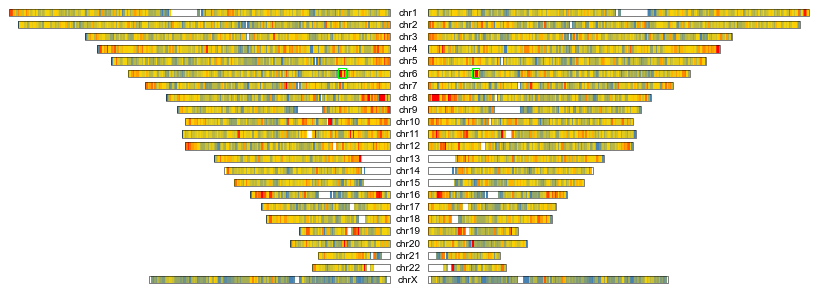

In [17]:
h = 0.6
mhc = [28510120, 33480577]

fig, axs = plt.subplots(1, 2, figsize=(11.5, 4), sharex=False, sharey=False, 
                        gridspec_kw={"wspace": 0.1, "left": 0.01, "right": 0.98, "top": 0.98, "bottom": 0.01})

for hp in [0, 1]:
    ax = axs[hp]
    plt.sca(ax)
    for loc in ["top", "left", "right", "bottom"]:
        ax.spines[loc].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    # plt.yticks(np.arange(len(chroms)) * -1, chroms)
        
    # yticks
    if hp == 1:
        for i, chrom in enumerate(chroms):
            x = -13000000
            y = -i
            plt.text(x, y, chrom, ha="center",va="center")
    
    # chromosome edge
    xs = []
    ys = []
    for i, chrom in enumerate(chroms):
        y = -i
        x = len(snvs[chrom][0]) * width
        if hp == 0:
            x = -x
        xs.append(x)
        ys.append(y)
    plt.barh(ys, xs, height=h, edgecolor="black", color="none", lw=0.5, zorder=2, clip_on=False)
    
    # mhc
    if hp == 0:
        plt.barh([-5], [mhc[0] - mhc[1]], left=[-mhc[0]], edgecolor="lime", color="none", height=h + 0.2, zorder=3)
    else:
        plt.barh([-5], [mhc[1] - mhc[0]], left=[mhc[0]], edgecolor="lime", color="none", height=h + 0.2, zorder=3)

    # density
    xs = []
    ys = []
    lefts = []
    colors = []
    for i, chrom in enumerate(chroms):
        for j, count in enumerate(snvs[chrom][hp]):
            if count == 0:
                continue
            x = width
            if hp == 0:
                x = -width
                lefts.append(-j * width)
            else:
                x = width
                lefts.append(j * width)
            y = -i
            xs.append(x)
            ys.append(y)
            color = get_color(count)
            colors.append(color)
    plt.barh(ys, xs, height=h, left=lefts, color=colors, clip_on=False)
    
    plt.ylim(-len(chroms) + 0.5, 0.5)
    if hp == 0:
        plt.xlim(-250000000, 0)
    else:
        plt.xlim(0, 250000000)
    
plt.savefig("figures/haplotyped_snv_distribution.barh.pdf", dpi=300)